In [1]:
import sys
sys.path.append('../algorithms')
sys.path.append('../datasets')

import torch

import matplotlib.pyplot as plt

from datasets import HSIDataset
from tv_plus_grad_alignement import TVGradAlignement
from nabla import nabla

from torchvision import transforms
from math import sqrt


In [2]:
# Define device (default is "cpu")
device = "cuda"

# Define dtype
dtype = torch.float32

# Define random seed
seed = 42
torch.manual_seed(seed)

# Define data path
data_path = '/home/y/Documents/Data/HSI/datasets/harvard.zarr'

In [9]:
# Loads ENMAP Hypecnet Datasets 
val_transform = transforms.Compose([transforms.ToTensor()]) # Transforms a the input data to torch tensors
dataset = HSIDataset(root_dir=data_path, split='train', transform=val_transform)

# Choose the index of the selected image in the dataset (ENMAP dataset contains 11 000 images)
idx = 0
x = dataset[idx].unsqueeze(0).to(device=device,dtype=dtype) # import image to device (cpu or gpu), sizes of x is [1,number of bands, width, height]
# Adds a small amount of white gaussian noise to the input HSI (sigma2 = 1e-4)
x += 1e-2*torch.rand_like(x, device=device, dtype=dtype)/torch.norm(x)

# Compute the panchromatic image from the ground truth HSI
panc = torch.sum(x, dim=1).unsqueeze(1)/x.shape[1]
grad_panc = nabla(panc)

# Adds noise to the input HSI
sigma2 = 0.1/torch.norm(x)**2
y = x + sqrt(sigma2)*torch.randn_like(x, device=device, dtype=dtype)


In [12]:

# Define the solver parameters
params = {}

params['compute_L'] = {'nband': x.shape[1]}
params['K'] = {}
params['K_adjoint'] = {}
params['prox_sigma_g_conj'] = {'eps': 1e-12}
params['prox_tau_f'] = {'y': y, 'sigma2': 1}
params['loss_fn'] = {'sigma2': 1}

sigma = 0.99
tau = 0.99
optim = TVGradAlignement(max_iter=1000, mu=10, lmbda=0.1, theta=1, sigma=sigma, tau=tau, grad_panc=grad_panc)

x_est, loss = optim(y, init=None, verbose=True, params=params)

Chambolle Pock algorithm starting...
Iteration:  0 relative variation:  tensor(0.0119, device='cuda:0')
Cost function:  tensor(27167.4609)
Iteration:  1 relative variation:  tensor(0.0108, device='cuda:0')
Cost function:  tensor(25916.0059)
Iteration:  2 relative variation:  tensor(0.0099, device='cuda:0')
Cost function:  tensor(24788.2246)
Iteration:  3 relative variation:  tensor(0.0090, device='cuda:0')
Cost function:  tensor(23771.6367)
Iteration:  4 relative variation:  tensor(0.0082, device='cuda:0')
Cost function:  tensor(22854.9648)
Iteration:  5 relative variation:  tensor(0.0075, device='cuda:0')
Cost function:  tensor(22028.0156)
Iteration:  6 relative variation:  tensor(0.0068, device='cuda:0')
Cost function:  tensor(21281.5879)
Iteration:  7 relative variation:  tensor(0.0062, device='cuda:0')
Cost function:  tensor(20607.3730)
Iteration:  8 relative variation:  tensor(0.0057, device='cuda:0')
Cost function:  tensor(19997.8945)
Iteration:  9 relative variation:  tensor(0.0

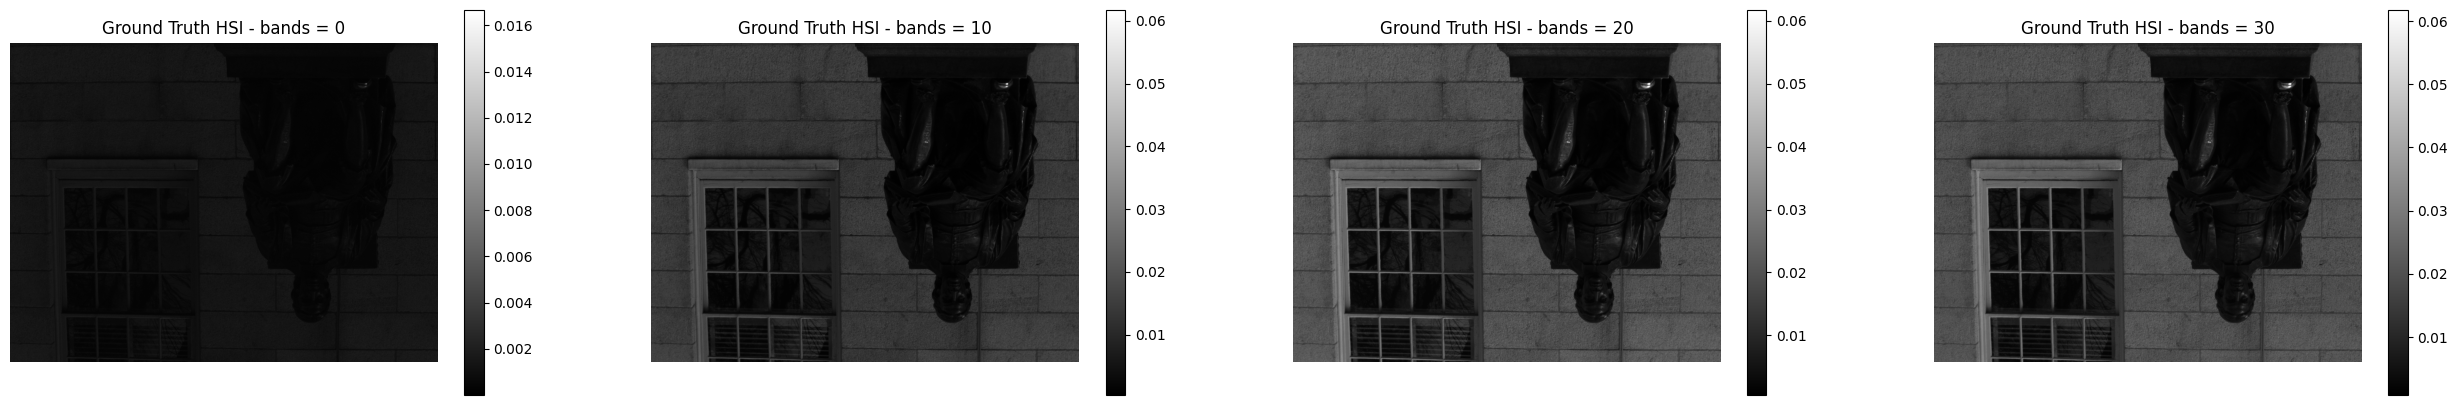

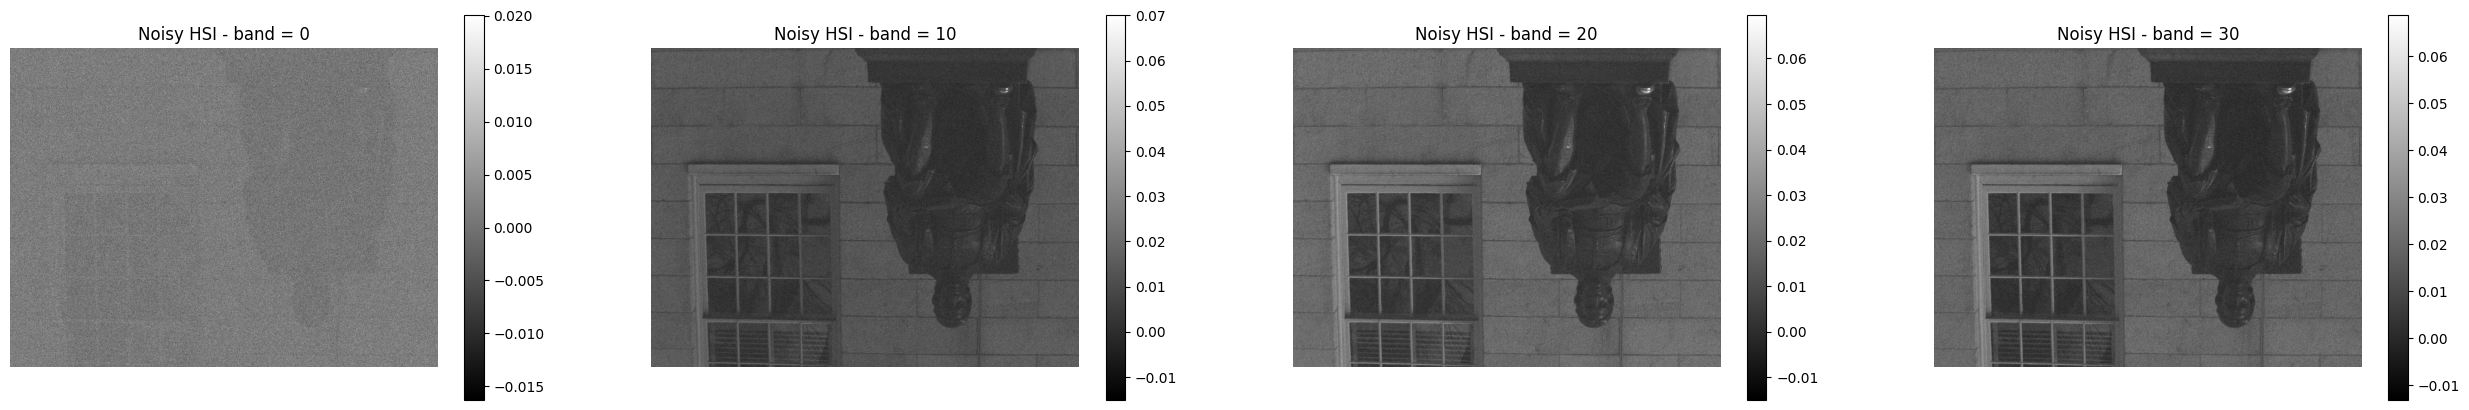

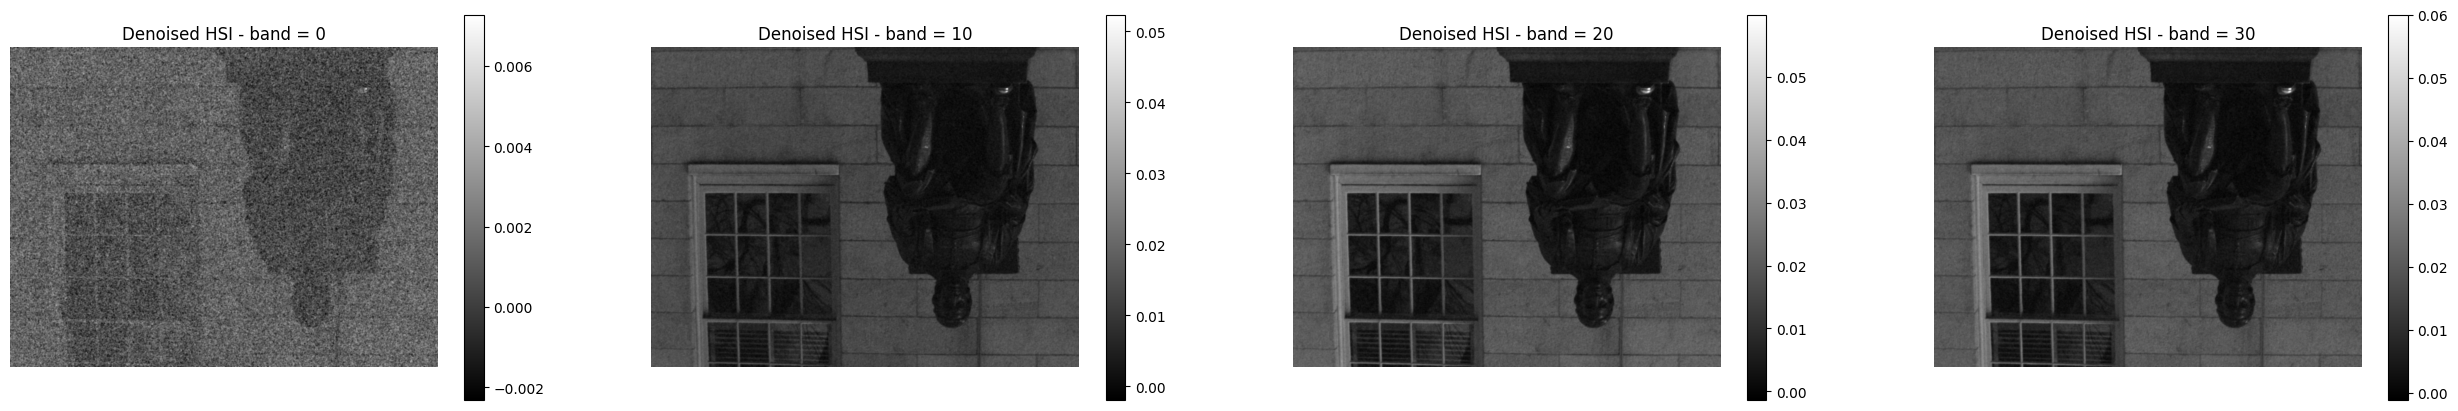

In [19]:


out = x_est
cmap = 'gray'

band_index = [0, 10,20,30]

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(x[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Ground Truth HSI - bands = {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(y[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Noisy HSI - band = {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(40, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(out[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Denoised HSI - band = {}'.format(idx))
    plt.axis('off')

plt.show()

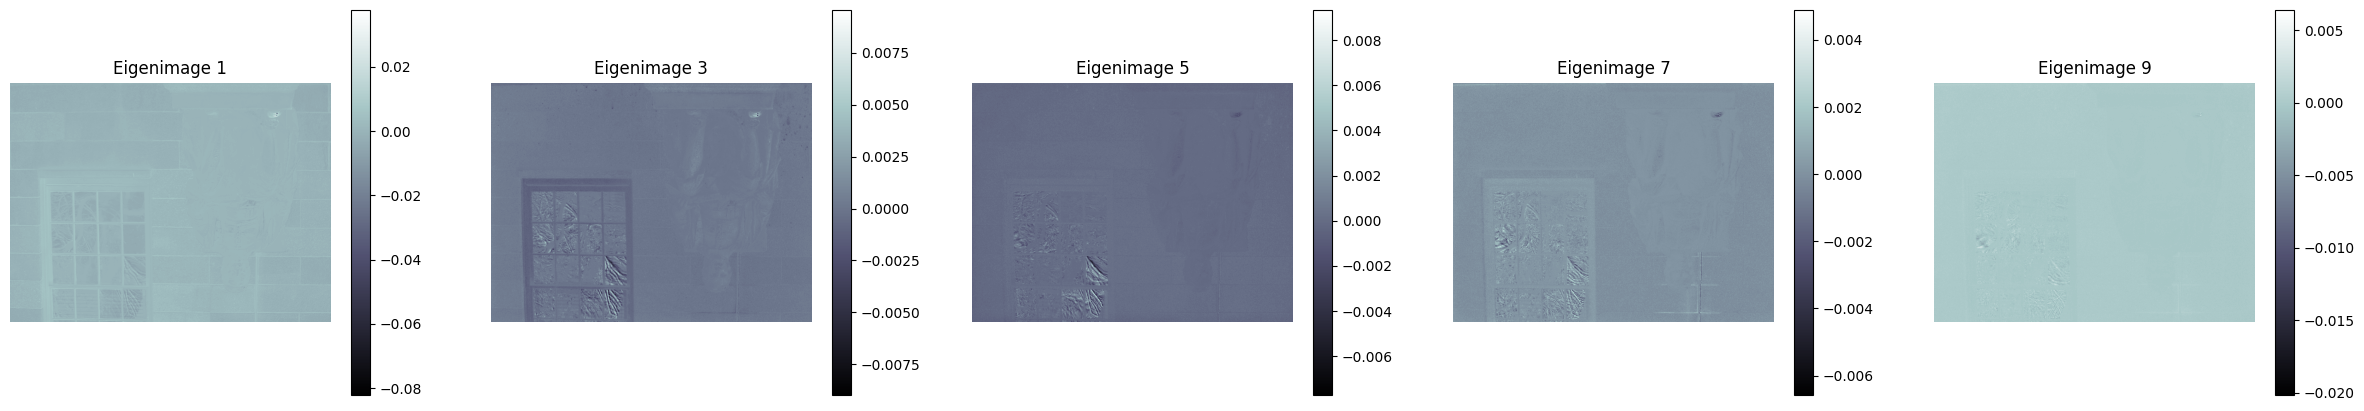

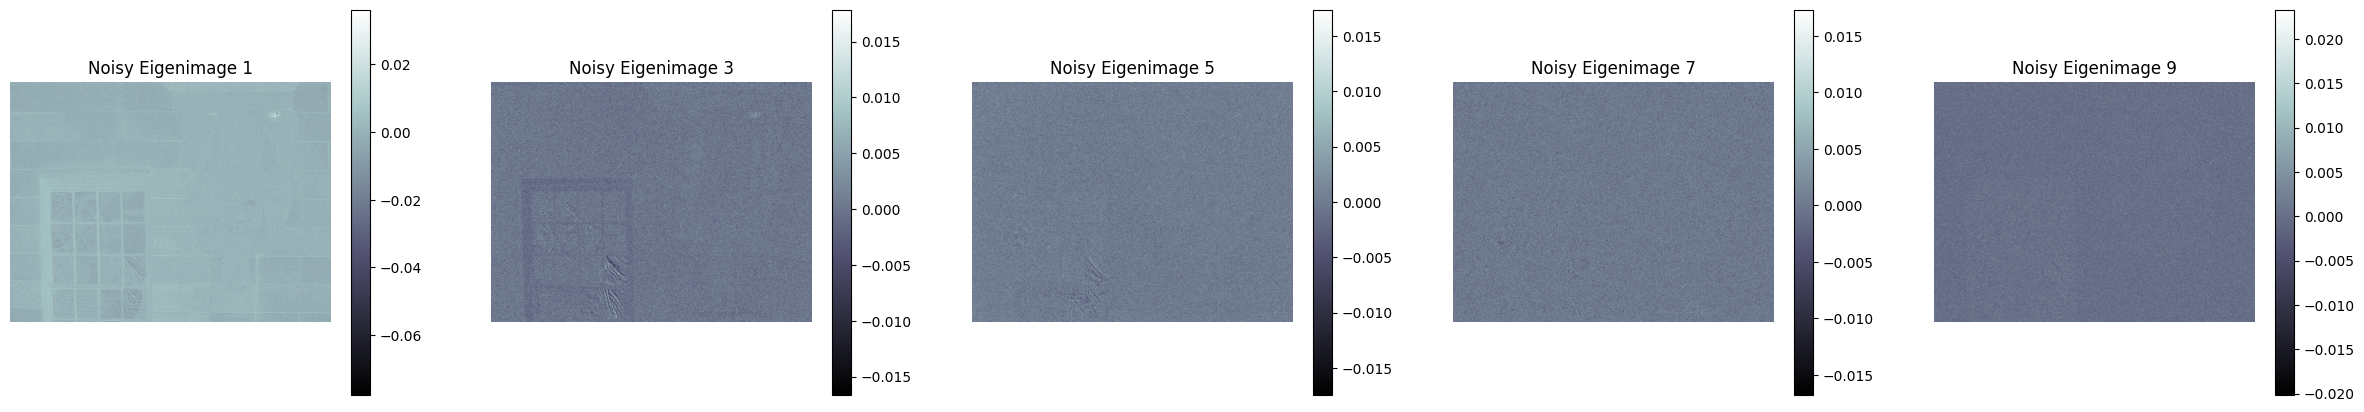

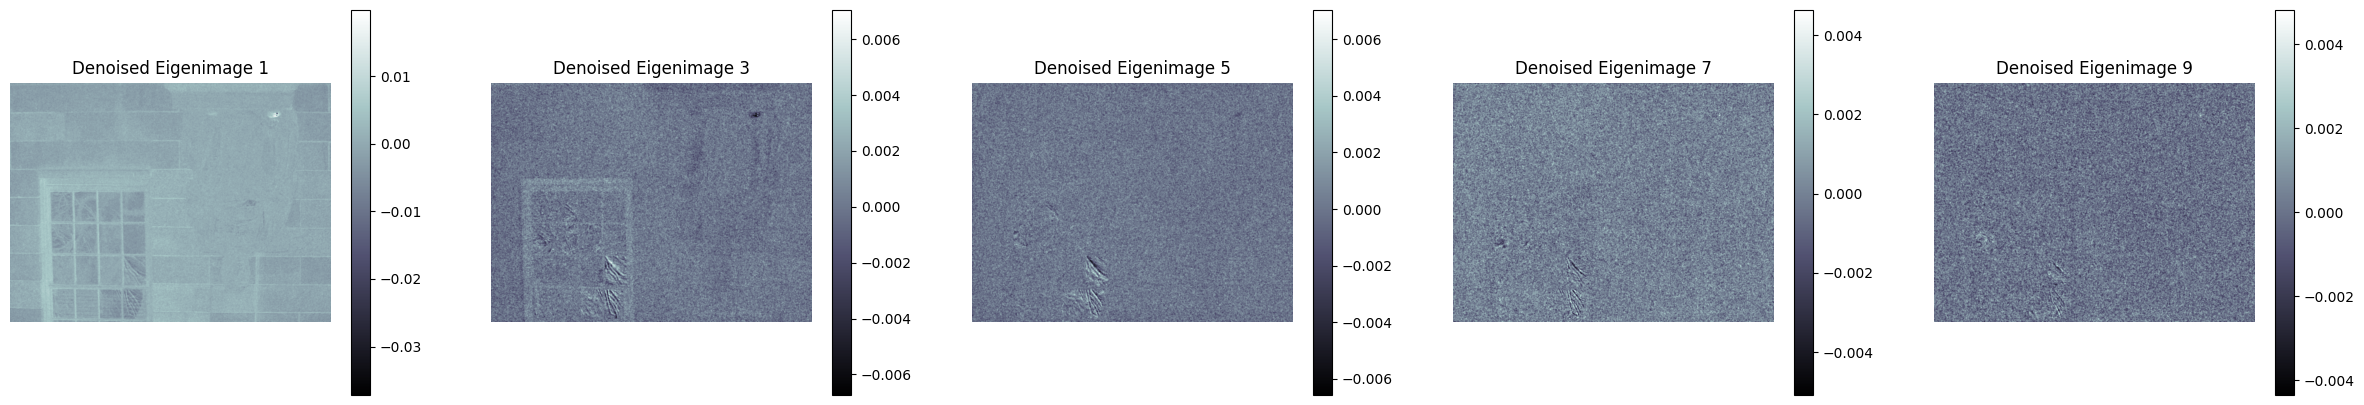

In [14]:
from datasets import get_eigenimages

z = get_eigenimages(x)
z_est = get_eigenimages(x_est)
z_noisy = get_eigenimages(y)

eigen_index = [1,3,5,7,9]

cmap = 'bone'

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Eigenimage {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_noisy[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Noisy Eigenimage {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_est[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Denoised Eigenimage {}'.format(idx))
    plt.axis('off')

plt.show()